This notebook contains inspections on the raw dataset and extracted graph.

In [48]:
import matplotlib.pyplot as plt
import collections
from pyvis.network import Network
import networkx as nx
from dataset import load_lnctard, df2nx

### 📂 Load dataset

In [10]:
df = load_lnctard(); f"loaded dataset with {len(df)} samples"

'loaded dataset with 7438 samples'

In [9]:
df.head()

,Regulator,Target,SearchregulatoryMechanism,RegulatorType,TargetType
0,LINC00313,miR-4429,ceRNA or sponge,lncRNA,miRNA
1,FAM83H-AS1,CDKN1A,epigenetic regulation,lncRNA,PCG
2,NEAT1,TGFB1,ceRNA or sponge,lncRNA,PCG
3,NEAT1,ZEB1,ceRNA or sponge,lncRNA,TF
4,ZFPM2-AS1,MIF,interact with protein,lncRNA,PCG


### 📊 Type distributions

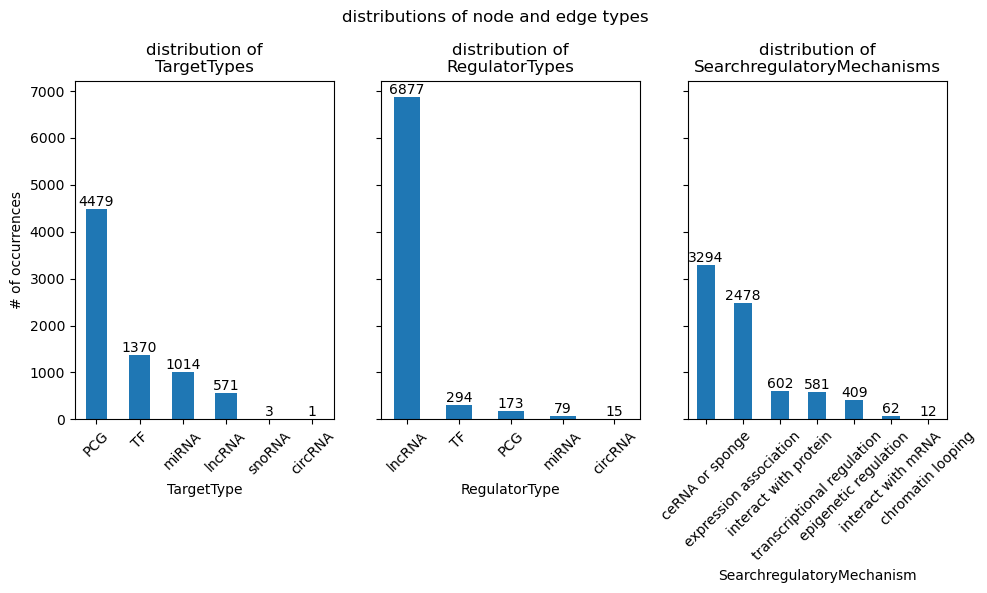

In [12]:
dis_features = ["TargetType", "RegulatorType", "SearchregulatoryMechanism"]
fig, axs = plt.subplots(ncols=len(dis_features), figsize=(10,6), sharey=True)
fig.suptitle("distributions of node and edge types")
for ax, ty in zip(axs, dis_features):
  # show distribution with bar plot
  df[ty].value_counts().plot(
    kind="bar", ax=ax, title=f"distribution of\n{ty}s",
    ylabel="# of occurrences", rot=45,
  )
  # stick numbers on bars
  for cont in ax.containers:
    ax.bar_label(cont)
fig.tight_layout()

In [13]:
(f'there are {df["Regulator"].nunique()} different Regulators, and ' +
 f'{df["Target"].nunique()} different Targets')

'there are 1599 different Regulators, and 2758 different Targets'

### Load networkx graph

In [18]:
# load graph G and connection components
G, conn_comps = df2nx(
  df,
  head="Regulator", tail="Target", relation="SearchregulatoryMechanism",
  cc_mode="all",
)
len(conn_comps)

249

In [21]:
largest_cc = conn_comps[0]
len(largest_cc), len(conn_comps[1]) # size of largest and 2nd largest CC

(3367, 6)

### 🧐 2nd largest CC inspections

inspect which types of regulators and targets occur in 2nd largest CC

In [42]:
snd_cc = G.subgraph(conn_comps[1])

In [23]:
df[df["Regulator"].isin(conn_comps[1])][["Regulator", "RegulatorType"]].drop_duplicates()

,Regulator,RegulatorType
177,IFNG-AS1,lncRNA
5325,IFN¦Ã,PCG
5326,IFN¦Ã,TF


In [24]:
df[df["Target"].isin(conn_comps[1])][["Target", "TargetType"]].drop_duplicates()

,Target,TargetType
177,ESRP2,PCG
1239,HLA-DRB1,PCG
5325,IFNG-AS1,lncRNA
5326,MAFTRR,lncRNA
8247,miR-627-3p,miRNA


In [41]:
nt = Network(notebook=True, cdn_resources="remote", directed=True)
nt.from_nx(snd_cc)
# HACK: pyvis expects the label to be in a field called exactly "label"
for e in nt.edges:
  e["label"] = e["SearchregulatoryMechanism"]
nt.show("snd.html")

snd.html


### 🧐 Largest CC inspections

In [43]:
largest_cc = G.subgraph(conn_comps[0])

In [46]:
# nt = Network(notebook=True, cdn_resources="remote", directed=True)
# nt.barnes_hut()
# nt.from_nx(largest_cc)
# # HACK: pyvis expects the label to be in a field called exactly "label"
# for e in nt.edges:
#  e["label"] = e["SearchregulatoryMechanism"]
# nt.show("largest.html")

/tmp/ipykernel_16657/1442386787.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())


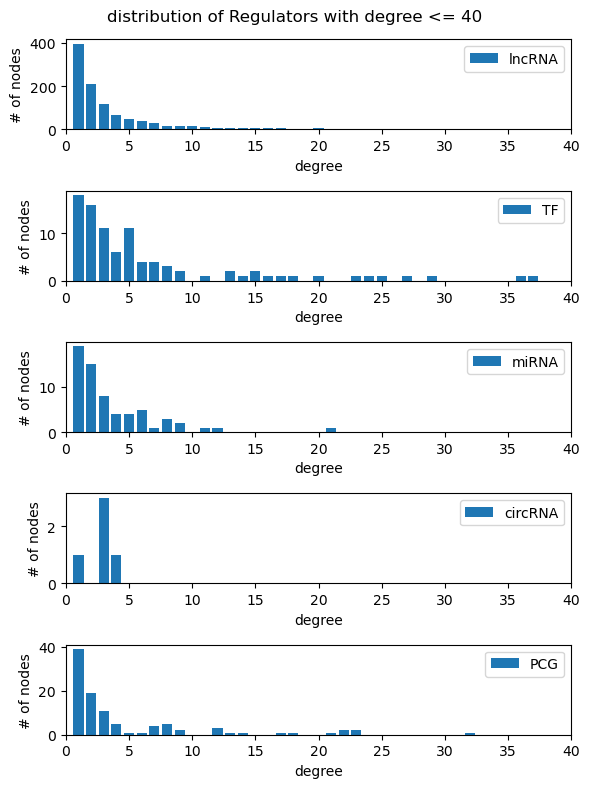

In [55]:
plt.figure(figsize=(6,8))
regtys = df["RegulatorType"].drop_duplicates()
for idx, regty in enumerate(regtys):
  regs = df[df["RegulatorType"] == regty]["Regulator"].drop_duplicates()
  _, degrees = zip(*largest_cc.degree(regs))
  degrees = collections.Counter(degrees)
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())
  plt.bar(degrees.keys(), degrees.values(), label=regty)
  #plt.hist(degrees.values(), list(degrees.keys()), label=regty)
  plt.xlabel("degree")
  plt.ylabel("# of nodes")
  plt.legend()
plt.xlim(0,40)
plt.suptitle("distribution of Regulators with degree <= %d" % plt.xlim()[1])
plt.gcf().tight_layout()

/tmp/ipykernel_16657/949713432.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(tartys), 1, idx + 1, sharex=plt.gca())


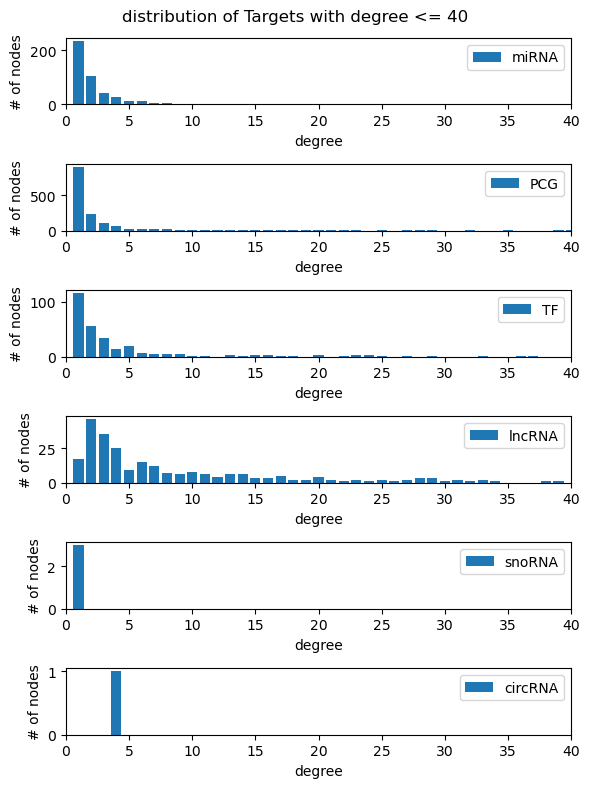

In [59]:
plt.figure(figsize=(6,8))
tartys = df["TargetType"].drop_duplicates()
for idx, tarty in enumerate(tartys):
  tars = df[df["TargetType"] == tarty]["Target"].drop_duplicates()
  _, degrees = zip(*largest_cc.degree(tars))
  degrees = collections.Counter(degrees)
  plt.subplot(len(tartys), 1, idx + 1, sharex=plt.gca())
  plt.bar(degrees.keys(), degrees.values(), label=tarty)
  #plt.hist(degrees.values(), list(degrees.keys()), label=regty)
  plt.xlabel("degree")
  plt.ylabel("# of nodes")
  plt.legend()
plt.xlim(0,40)
plt.suptitle("distribution of Targets with degree <= %d" % plt.xlim()[1])
plt.gcf().tight_layout()